# Test reference implementation

Reference: [evidential-learning-pytorch](https://github.com/teddykoker/evidential-learning-pytorch)

TODO: implement regression tasks.

In [3]:
import sys
import os

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [4]:
# include parent path
sys.path.append(os.path.abspath('..'))

In [5]:

from pineberry.models.utils.layers import NormalInvGamma
from pineberry.models.utils.losses import evidential_regression

In [6]:
torch.manual_seed(0)

x_train = torch.linspace(-4, 4, 1000).unsqueeze(-1)
sigma = torch.normal(torch.zeros_like(x_train), 3 * torch.ones_like(x_train))
y_train = x_train**3 + sigma

x_test = torch.linspace(-7, 7, 1000).unsqueeze(-1)
y_test = x_test**3

model = nn.Sequential(
    nn.Linear(1, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for _ in range(500):
    for x, y in DataLoader(
        TensorDataset(x_train, y_train), batch_size=100, shuffle=True
    ):
        pred = model(x)
        loss = evidential_regression(pred, y, lamb=1e-2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

with torch.no_grad():
    pred = model(x_test)

mu, v, alpha, beta = (d.squeeze() for d in pred)
x_test = x_test.squeeze()
var = torch.sqrt(beta / (v * (alpha - 1)))

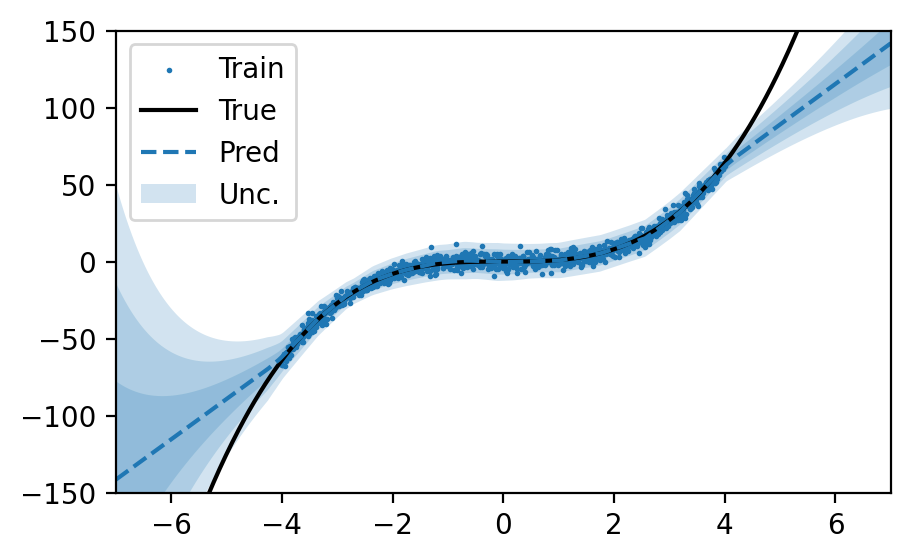

In [7]:
# plot code modified from
# https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
plt.figure(figsize=(5, 3), dpi=200)
plt.scatter(x_train, y_train, s=1.0, c="tab:blue", label="Train")
plt.plot(x_test, y_test, c="k", label="True")
plt.plot(x_test, mu, c="tab:blue", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        x_test,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.show()
# plt.savefig("examples/cubic.png")